In [73]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import numpy as np
from torch.utils.data import Dataset,DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pathlib



file_path = './data'
p = pathlib.Path(file_path)

df=pd.read_csv('./data/051910.csv',index_col=0).reset_index(drop=True)
# df=pd.read_csv('./data/215600.csv',index_col=0).reset_index(drop=True)
code_name=pd.read_csv('./data/code_name.csv')
train=df[['open','high','low','volume']]
target=df[['close']]
dates=df.date

In [74]:
train_scaler=StandardScaler()
train=train_scaler.fit_transform(train) #returns numpy array
close_scaler=StandardScaler()
target=close_scaler.fit_transform(target) #returns numpy array

In [2]:
change_ratio=target[1:].reset_index(drop=True)/target[:-1].reset_index(drop=True)
change_ratio.describe()

,close
count,4618.000000
mean,1.001048
std,0.026844
min,0.850856
25%,0.987132
50%,1.000000
75%,1.013797
max,1.416667


In [25]:
class custom_dataset(Dataset):
    '''batch sample?'''
    
    def __init__(self,train,target,window_size=7):
        '''train : numpy , target : numpy'''
        self.window_size=window_size
        self.train=train
        self.target=target
        self.len=train.shape[0]
        
#         self.scaler=StandardScaler()
#         self.close_scaler=StandardScaler()
        
#         self.scaled_train=self.scaler.fit_transform(self.train)
#         self.sclaed_target=self.close_scaler.fit_transform(self.target)
        
    def __getitem__(self,index):
        
        '''scaler 문제일 것 같다?? 처음꺼는 scaling이 잘 안되니까'''
        
#         normalized_train=self.scaler.fit_transform(self.train[index:index+self.window_size])
        
#         normalized_c=self.close_scaler.fit_transform(self.target[index:index+self.window_size])
#         c_input=np.append(normalized_c[:-1],0).reshape(-1,1)

        normalized_train=self.train[index:index+self.window_size]
        
        normalized_c=self.target[index:index+self.window_size]
        c_input=np.append(normalized_c[:-1],0).reshape(-1,1)

        train_with_zeropadding=np.concatenate((normalized_train,c_input),axis=1)
        
        return train_with_zeropadding,normalized_c[-1]
    
    
    
    def __len__(self):
        return self.len-self.window_size

In [54]:
def split_data(data):
    '''train,val,test 나누기'''
    prop=len(data)//5
    val=data[:prop]
    test=data[prop+1:2*prop]
    train=data[2*prop:]
    
    return train,val,test


class plot_time:
    '''predict : np.array, y : np.array'''
    
    def __init__(self,predict,y,dates):
        
        assert predict.shape[0]==y.shape[0]
        self.data_len=predict.shape[0]
        self.prediction=predict
        self.prediction=pd.DataFrame(prediction,columns={'prediction'})
        self.y=pd.DataFrame(y,columns={'close'})
        
        self.comparing=pd.concat([self.prediction,self.y.reset_index(drop=True)],axis=1)
        self.comparing.index = dates  
        
    def plot_(self):
        
        self.comparing[['prediction','close']].plot()
    
    

# def make_seq(data,window_size):
#     seq_data=[]
#     for i in range(data.shape[0]-window_size):
#         L=data[i:i+window_size]
#         seq_data.append(L)
#     return seq_data

# def make_nomarlized_seq(data,window_size):
#     '''input : pandas df, window size만큼만 normalize'''
#     seq_data=[]
#     scaler= StandardScaler()
#     for i in range(data.shape[0]-window_size):
#         L=data[i:i+window_size]
#         seq_data.append(scaler.fit_transform(np.array(L)))
        
#     return np.array(seq_data),scaler

# def preprocessing(data):
#     '''정규화 및 numpy array return : 이제 안쓸듯'''
#     scaler= StandardScaler()
#     data=scaler.fit_transform(data)
#     data=np.array(data)
    
#     return data


# train_data_normalized,scaler_train = preprocessing(train.iloc[:-1])
# target_data_normalized ,scaler_test= preprocessing(target.iloc[1:])

# train_seq=make_seq(train_data_normalized,window_size=5)
# target_seq=make_seq(target_data_normalized,window_size=5)

# '''making normalized window'''
# train_seq,train_scaler=make_nomarlized_seq(train.iloc[:-1],window_size=5)
# test_seq,test_scaler=make_nomarlized_seq(target.iloc[1:],window_size=5)

In [75]:
x_train,x_val,x_test=split_data(train)
y_train,y_val,y_test=split_data(target)

In [76]:
train_dataset=custom_dataset(train=x_train,target=y_train)
val_dataset=custom_dataset(train=x_val,target=y_val)

train_loader=DataLoader(train_dataset,batch_size=8,shuffle=True)
test_loadr=DataLoader(train_dataset,batch_size=1)
val_laoder=DataLoader(val_dataset,batch_size=1)

### LSTM을 이용한 예측

In [32]:
class stock_net(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        
        super(stock_net, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.h_o=nn.Linear(hidden_dim,1)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        
        x=self.lstm(x)

        x=self.relu(self.h_o(x[0][-1,:,:]))

        
        return x

In [33]:
emb_dim=5# feature size

In [34]:
haha_net=stock_net(emb_dim,16)
criterion = nn.MSELoss()
optimizer = optim.SGD(haha_net.parameters(), lr=0.0001)

In [40]:
a=[1,2]
sum(a)

3

In [45]:
# Loss=[]
# epoch=1
# for y in range(epoch):
#     for i in range(x_train.shape[0]):

#         optimizer.zero_grad()
#         output=haha_net(torch.FloatTensor(x_train[i]).view(5,-1,4))
#         loss = criterion(output, torch.FloatTensor(y_train[i]))
#         loss.backward()
#         optimizer.step()  
#         if i%100==0:
#             Loss.append(loss.item())
#             print('epoch/step',y,i,':',loss.item())

Loss=[]
epochs=50
for i in range(epochs):
    for idx,data in enumerate(train_loader):
        
        optimizer.zero_grad()
      
        train=data[0].permute(1,0,2)

        y=data[1]
    
        output=haha_net(train.float())

        loss = criterion(output,y.float())
        loss.backward()
        optimizer.step()  
        if (idx+1)%100==0:
            Loss.append(loss.item())
            print('epoch/step',i+1,idx,':',loss.item())
            
            
    
    
    '''val loss 하나씩 읽어야되나????'''
    val_loss=[]    
    for idx,data in enumerate(val_laoder):
        val=data[0].permute(1,0,2)
        y=data[1]
        output=haha_net(train.float())
        loss=criterion(output,y.float())        
        val_loss.append(loss.item())

    print("Epoch: %d val_loss: %.3f " %(i+1,sum(val_loss)/len(val_loss)))
        

epoch/step 1 99 : 0.4267062544822693
epoch/step 1 199 : 0.35456568002700806
epoch/step 1 299 : 0.05023026466369629
Epoch: 0 val_loss: 3.096132 
epoch/step 2 99 : 0.2803364396095276
epoch/step 2 199 : 0.3193659782409668
epoch/step 2 299 : 0.09019368886947632
Epoch: 1 val_loss: 3.218867 
epoch/step 3 99 : 0.042378753423690796
epoch/step 3 199 : 0.05865110456943512
epoch/step 3 299 : 0.06388396769762039
Epoch: 2 val_loss: 3.607262 
epoch/step 4 99 : 0.42313945293426514
epoch/step 4 199 : 0.1313188374042511
epoch/step 4 299 : 0.06409124284982681
Epoch: 3 val_loss: 3.610295 
epoch/step 5 99 : 0.17386864125728607
epoch/step 5 199 : 0.0956224724650383
epoch/step 5 299 : 0.07086850702762604
Epoch: 4 val_loss: 2.991184 
epoch/step 6 99 : 0.0696774497628212
epoch/step 6 199 : 0.09072433412075043
epoch/step 6 299 : 0.048323988914489746
Epoch: 5 val_loss: 3.700757 
epoch/step 7 99 : 0.09834489971399307
epoch/step 7 199 : 0.13656075298786163
epoch/step 7 299 : 0.1812225729227066
Epoch: 6 val_loss: 

In [46]:
Prediction=[]
for idx,data in enumerate(test_loadr):
    train=data[0].permute(1,0,2)
    y=data[1]
    output=haha_net(train.float())
    Prediction.append(output.item())

Text(0.5, 1.0, 'Train Data')

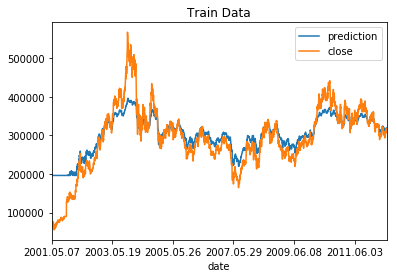

In [58]:
prediction=close_scaler.inverse_transform(Prediction)
y_train=close_scaler.inverse_transform(y_train)
to_plot=plot_time(prediction,y_train[7:],dates[7:7+prediction.shape[0]])
to_plot.plot_()
plt.title('Train Data')

In [77]:
Prediction=[]
for idx,data in enumerate(val_laoder):
    train=data[0].permute(1,0,2)
    y=data[1]
    output=haha_net(train.float())
    Prediction.append(output.item())

Text(0.5, 1.0, 'Val Data')

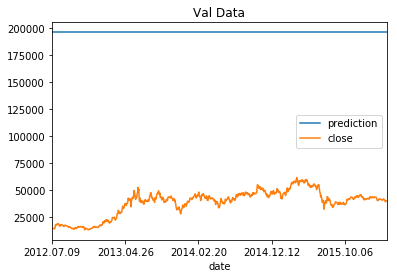

In [78]:
prediction=close_scaler.inverse_transform(Prediction)
y_bakc_norm=close_scaler.inverse_transform(y_val)
to_plot=plot_time(prediction,y_bakc_norm[7:],dates[y_train.shape[0]+7:y_train.shape[0]+7+prediction.shape[0]])
to_plot.plot_()
plt.title('Val Data')

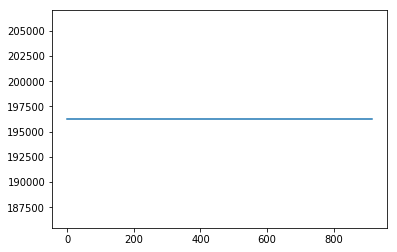

In [79]:
plt.plot(prediction)

## Test Loader 만들어야됨

In [76]:
Prediction=[]
for i in x_test:
    prediction=haha_net(torch.FloatTensor(i).view(5,-1,4))
    Prediction.append(prediction.view(-1).detach().numpy()[-1])  #many to many 라 마지막 종가만 추가

TypeError: new(): invalid data type 'str'

In [68]:
Prediction=np.array(Prediction).reshape(-1)
print(Prediction.shape)

(921,)


In [69]:
prediction=test_scaler.inverse_transform(Prediction.reshape(-1,1))
prediction=pd.DataFrame(prediction,columns={'prediction'})

In [70]:
comparing=pd.concat([prediction,target.iloc[-y_test.shape[0]:].reset_index(drop=True)],axis=1)
comparing.index = pd.to_datetime(dates.iloc[-y_test.shape[0]:])

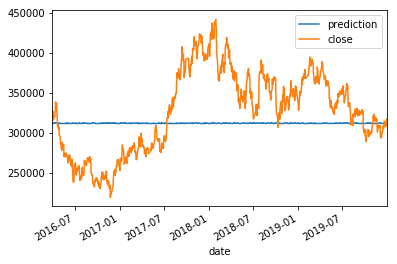

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

comparing[['prediction','close']].plot()

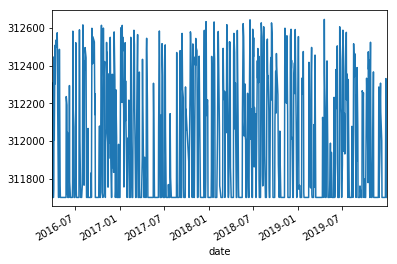

In [72]:
comparing['prediction'].plot()